In [0]:
import pandas as pd
import numpy as np
from datetime import datetime

def func_time(x):
    x = datetime.strptime(x,'%m/%d/%Y')
    x = datetime.strftime(x,'%Y-%m-%d')
    return x

def func_year(x):
    return int(x[:4])

def func_month(x):
    return int(x[5:7])

def func_week(x):
    return datetime.strptime(x,'%Y-%m-%d').weekday()

def func_day(x):
    return int(x[8:10])

df = pd.read_csv('Origin_02.csv')
df = df.iloc[:,1:]

df['date'] = df['Date Local'].apply(func_time)
df['year'] = df['date'].apply(func_year)
df['month'] = df['date'].apply(func_month)
df['weekday'] = df['date'].apply(func_week)
df['day'] = df['date'].apply(func_day)

pollutant_keys = ['NO2','O3','SO2','CO']
pollutant_vals = [' Full Mean (standard)',' Full 1st Max Value (standard)',' Full 1st Max Hour (standard)']
all_indicators = []
for x1 in pollutant_keys:
    for x2 in pollutant_vals:
        all_indicators.append(x1+x2)

In [0]:


identifier = ['State','date']
time_feature = ['year','month','weekday','day']
df = df.groupby(identifier).mean().reset_index()

# 简化dataframe
df = df[identifier + time_feature + all_indicators]
df = df[df['State'] == 'District Of Columbia']

In [0]:
# Taking the display of the 0th prediction target as an example, in order to predict the number of indicators, 
# it is only necessary to make further downward changes and finally become a function.
target = all_indicators[0]

# set label to predict next day
labels = df[['date',target]].copy()
labels[target] = df[target].shift(-1)
labels.columns = ['date','label']

# moving average

# The window has 4 values, because the characteristics of the week are very obvious, and the 4 values 
# represent the week, month, quarter, and year.
windows = [7*i for i in [1,4,13,52]]
self_df = df[all_indicators].copy()
self_df0 = self_df.rolling(window=windows[0]).mean()
self_df1 = self_df.rolling(window=windows[1]).mean()
self_df2 = self_df.rolling(window=windows[2]).mean()
self_df3 = self_df.rolling(window=windows[3]).mean()

self_df0.columns = [x+'_'+str(windows[0]) for x in all_indicators]
self_df1.columns = [x+'_'+str(windows[1]) for x in all_indicators]
self_df2.columns = [x+'_'+str(windows[2]) for x in all_indicators]
self_df3.columns = [x+'_'+str(windows[3]) for x in all_indicators]

dff = df.drop(['State'],axis=1).copy()
dff = pd.concat([dff,self_df0,self_df1,self_df2,self_df3],axis=1)

dff = pd.merge(labels,dff,on=['date','date'],how='outer')
dff = dff.dropna().reset_index(drop=True)

In [0]:
# The standard data finally obtained. This data is only in the DC region. 
# The date indicates the current, the label is the predicted target value for the next day, 
# and the other 4 + 4 * 3 * (4 + 1) = 64 columns of features, a total of 66 columns of data.
X = dff.drop(['date','label'],axis=1)
y = dff['label']

# split training set, validation set, and test set, accounting for 0.6, 0.2, and 0.2 respectively
train_begin = 0.6
dev_begin = 0.8

X_train = X[:int(train_begin*len(X))]
y_train = y[:int(train_begin*len(X))]
X_dev  = X[int(train_begin*len(X)):int(dev_begin*len(X))]
y_dev = y[int(train_begin*len(X)):int(dev_begin*len(X))]
X_test = X[int(dev_begin*len(X)):]
y_test = y[int(dev_begin*len(X)):]

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

model = GradientBoostingRegressor(max_depth=6,n_estimators=200)
model.fit(X_train,y_train)

# get the order of feature importance
impos = dict(zip(list(X_train.columns),list(model.feature_importances_)))
impos = sorted(impos.items(),key=lambda x:x[1],reverse=True)
impos = [x[0] for x in impos]

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
# According to the order of feature importance, the top n features are selected in turn, the validation 
# set is used to select the best rmse, and the features are filtered in order.
# take a long time....
rmses = []
for i in range(1,len(X_train.columns)):
    cols = impos[:i]
    X_train2 = X_train[cols].copy()
    X_dev2 = X_dev[cols].copy()
    model = GradientBoostingRegressor(max_depth=6,n_estimators=200)
    model.fit(X_train2,y_train)
    rmses.append(mean_squared_error(y_dev,model.predict(X_dev2)))
    print(i,' finished')

1  finished
2  finished
3  finished
4  finished
5  finished
6  finished
7  finished
8  finished
9  finished
10  finished
11  finished
12  finished
13  finished
14  finished
15  finished
16  finished
17  finished
18  finished
19  finished
20  finished
21  finished
22  finished
23  finished
24  finished
25  finished
26  finished
27  finished
28  finished
29  finished
30  finished
31  finished
32  finished
33  finished
34  finished
35  finished
36  finished
37  finished
38  finished
39  finished
40  finished
41  finished
42  finished
43  finished
44  finished
45  finished
46  finished
47  finished
48  finished
49  finished
50  finished
51  finished
52  finished
53  finished
54  finished
55  finished
56  finished
57  finished
58  finished
59  finished
60  finished
61  finished
62  finished
63  finished


In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(list(range(1,len(X.columns))),rmses)
plt.legend(['rmse'])
plt.show()
print('best N is :',np.argmin(np.array(rmses))+1)
print('Top N features are:',impos[:np.argmin(np.array(rmses))+1])

<Figure size 800x400 with 1 Axes>

best N is : 33
Top N features are: ['NO2 Full Mean (standard)', 'CO Full 1st Max Hour (standard)', 'O3 Full 1st Max Hour (standard)', 'CO Full 1st Max Hour (standard)_28', 'weekday', 'SO2 Full 1st Max Hour (standard)_7', 'CO Full Mean (standard)_7', 'O3 Full Mean (standard)', 'SO2 Full 1st Max Value (standard)_7', 'SO2 Full 1st Max Hour (standard)_28', 'CO Full 1st Max Value (standard)_7', 'SO2 Full 1st Max Hour (standard)_91', 'NO2 Full 1st Max Hour (standard)', 'SO2 Full Mean (standard)', 'CO Full 1st Max Hour (standard)_364', 'NO2 Full 1st Max Hour (standard)_28', 'NO2 Full Mean (standard)_7', 'NO2 Full 1st Max Value (standard)_28', 'NO2 Full 1st Max Hour (standard)_364', 'O3 Full 1st Max Value (standard)', 'O3 Full Mean (standard)_7', 'NO2 Full 1st Max Hour (standard)_7', 'NO2 Full Mean (standard)_364', 'NO2 Full 1st Max Value (standard)_7', 'SO2 Full Mean (standard)_7', 'NO2 Full 1st Max Value (standard)', 'NO2 Full Mean (standard)_91', 'CO Full 1st Max Value (standard)_28', 'CO F

model RMSE in test set is: 28.069524996172824
today predict tomorrow: 44.30579387724452


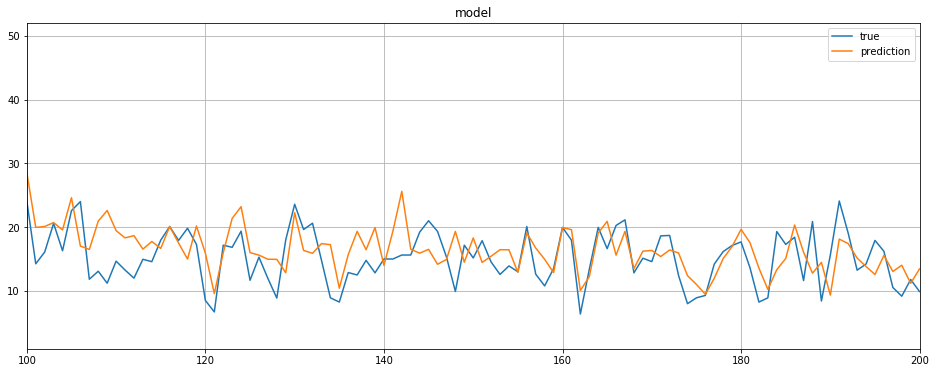

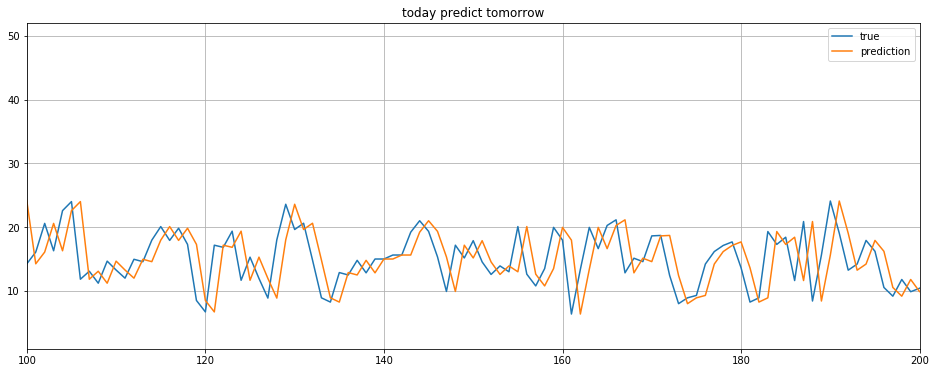

In [0]:
cols = impos[:np.argmin(np.array(rmses))+1]
X_train2 = X_train[cols].copy()
X_test2 = X_test[cols].copy()
model = GradientBoostingRegressor(max_depth=6,n_estimators=200)
model.fit(X_train2,y_train)
preds = model.predict(X_test2)
print('model RMSE in test set is:',mean_squared_error(y_test,preds))

# Regression indicators such as the rmse used here are not as intuitive as classification 
# indicators such as accuracy. So use today to predict tomorrow.
# The picture is actually easy to be misled, because it is difficult to see the difference in the dense picture 
# by translating a number. It can only be enlarged if you look closely.
# t can be seen that the rmse of the model is smaller, so this model is meaningful
print('today predict tomorrow:',mean_squared_error(list(y_test)[1:],list(y_test[:-1])))

plt.figure(figsize=(16,6))
plt.grid()
plt.title('model')
plt.xlim(100,200) 
plt.plot(list(y_test))
plt.plot(preds)
plt.legend(['true','prediction'])
plt.show()

plt.figure(figsize=(16,6))
plt.grid()
plt.title('today predict tomorrow')
plt.xlim(100,200)
plt.plot(list(y_test)[1:])
plt.plot(list(y_test)[:-1])
plt.legend(['true','prediction'])
plt.show()

In [0]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /anaconda3/lib/python3.7/site-packages (20.0.2)


In [0]:
!pip install shap

In [0]:
!pip install -U tqdm

Requirement already up-to-date: tqdm in /anaconda3/lib/python3.7/site-packages (4.43.0)


In [0]:
import shap
shap.initjs()

In [0]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test2)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
X_test2.iloc[0,:]

NO2 Full Mean (standard)                 15.916667
CO Full 1st Max Hour (standard)           1.000000
O3 Full 1st Max Hour (standard)          10.000000
CO Full 1st Max Hour (standard)_28        9.732143
weekday                                   3.000000
SO2 Full 1st Max Hour (standard)_7       12.785714
CO Full Mean (standard)_7                 2.692614
O3 Full Mean (standard)                   0.025333
SO2 Full 1st Max Value (standard)_7      11.100000
SO2 Full 1st Max Hour (standard)_28      11.178571
CO Full 1st Max Value (standard)_7        3.007143
SO2 Full 1st Max Hour (standard)_91      11.675824
NO2 Full 1st Max Hour (standard)          2.000000
SO2 Full Mean (standard)                  6.020834
CO Full 1st Max Hour (standard)_364       8.976648
NO2 Full 1st Max Hour (standard)_28      11.500000
NO2 Full Mean (standard)_7               23.339286
NO2 Full 1st Max Value (standard)_28     31.285714
NO2 Full 1st Max Hour (standard)_364     11.887363
O3 Full 1st Max Value (standard

In [0]:
ii = 11
shap.force_plot(explainer.expected_value, shap_values[ii,:], X_test2.iloc[ii,:])

In [0]:
shap_values[11]

array([ 3.64272591e+00, -8.38577903e-01, -6.37979802e+00,  3.69456043e-02,
        9.21049950e-01,  9.05092248e-01, -5.09143625e-01,  7.24196480e-02,
       -1.64580437e-01, -6.29872471e-02, -5.44594292e-01, -1.22586874e-02,
       -8.52086715e-01,  3.91236129e-01, -5.02556412e-01, -4.03342522e-01,
        4.14385804e-02,  5.05690600e-01,  7.92963753e-02,  2.33865244e-01,
        4.30273597e-02,  3.16926543e-02,  5.84503395e-02, -4.69612840e-01,
       -1.42642032e-02,  5.81502899e-01, -4.14657990e-01,  1.72445309e+00,
       -4.05918118e-03,  7.41107836e-01, -4.84350693e-02, -3.16597732e-01,
       -1.49858230e+00])

In [0]:
shap.force_plot(explainer.expected_value, shap_values, X_test2)

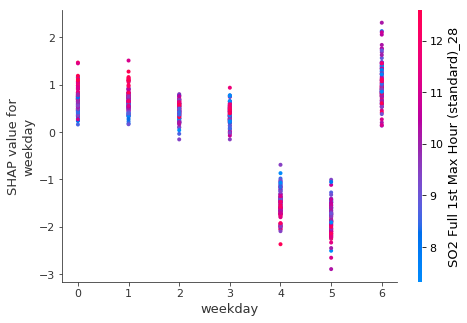

In [0]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("weekday", shap_values, X_test2)

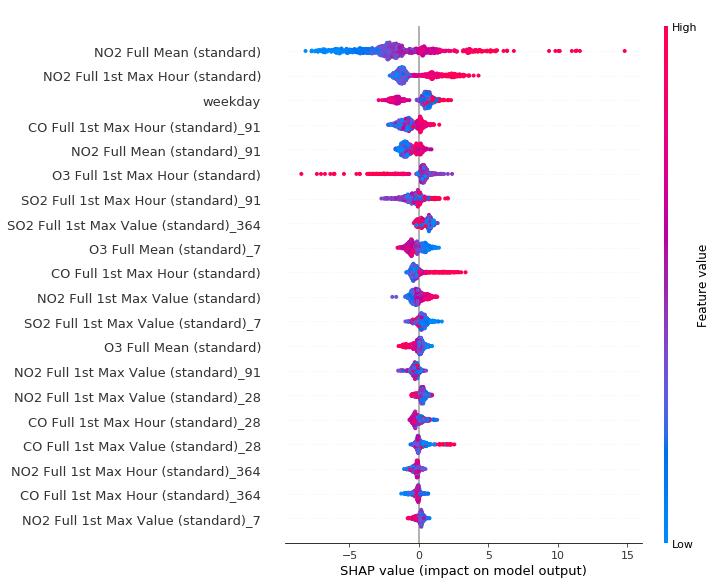

In [0]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test2)

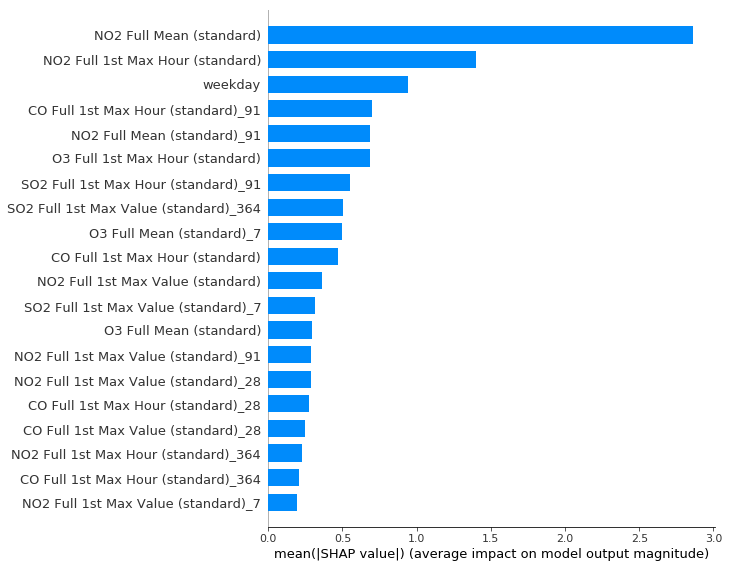

In [0]:
shap.summary_plot(shap_values,X_test2,plot_type = "bar")

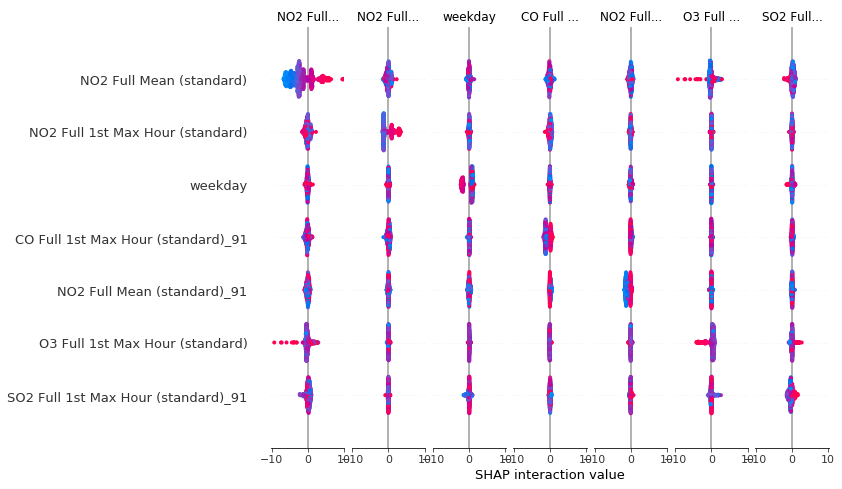

In [0]:
shap_interaction_values = explainer.shap_interaction_values(X_test2)
shap.summary_plot(shap_interaction_values, X_test2)

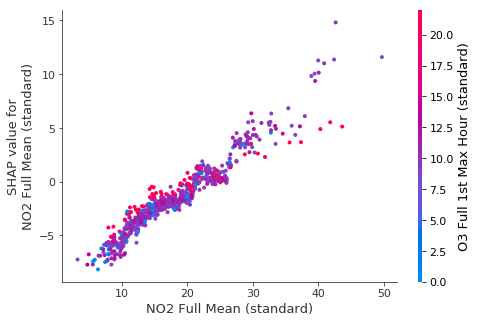

In [0]:
shap.dependence_plot("NO2 Full Mean (standard)",shap_values, X_test2)